In [55]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [56]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp)
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
print(df_all.head())
print(df_all_sorted.head())





astri_001_43_009_00002_R_201023_004_0201_SEB.lv0
astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
    TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0  15104575       0  15104575   2217  263211       1   
1  25307129       0  25307129   7009  263211       1   
2  28859186       0  28859186   2217  263212       1   
3  32680807       0  32680807   4213  263212       1   
4  35023796       0  35023796    417  263213       1   

                                                  HG  \
0  [[2158, 2264, 2118, 2251, 2150, 2144, 2247, 22...   
1  [[2251, 2145, 2137, 2122, 2236, 2138, 2146, 22...   
2  [[2107, 2316, 2213, 2026, 2181, 2110, 2212, 21...

In [74]:
dt = np.diff(df_all_sorted["TIME_ABS"])
logdt = np.log10(np.where(dt > 0, dt, 1e-12))

#per adesso cerco vicino il taglio queipochi eventi avvenuti simultaneamente ma diversi
mask =  (logdt < 3.2)

df_dt = df_all_sorted.iloc[1:][mask]


#df_dt= df_all_sorted[ (np.log10(np.diff(df_all_sorted["TIME_ABS"]) < 3.2))]


#sono tanti, prendo i più energetici
df_dt['shape']= df_dt['HG'].apply(np.sum).to_numpy()
df_dt.sort_values('TIME_ABS',ascending=True, inplace=True)
df_dt.head()
print(df_dt["shape"].max())
print(df_dt["shape"].min())
print(len(df_dt))
#df_dt = df_dt[df_dt["shape"] > 5200425 ]
print(len(df_dt))



5480425
5129820
18897
18897


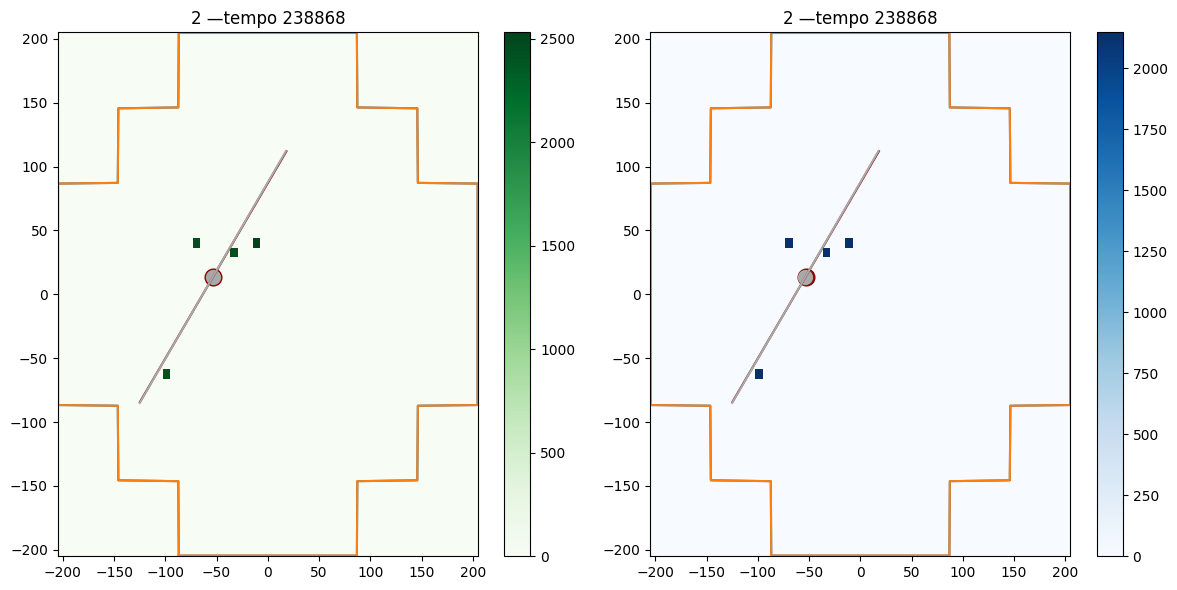

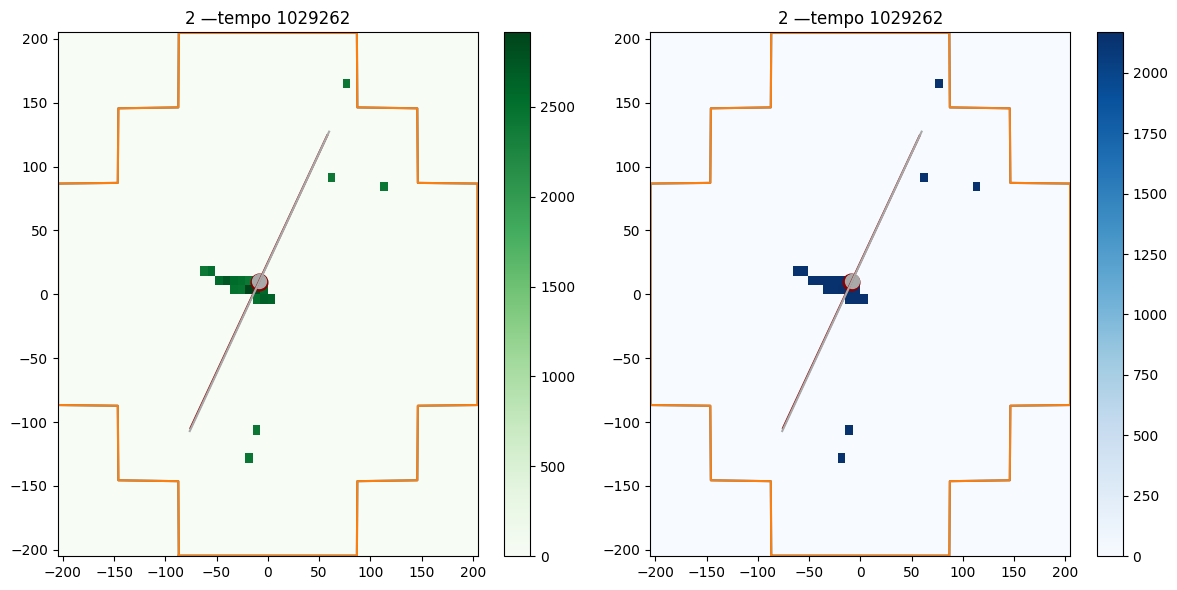

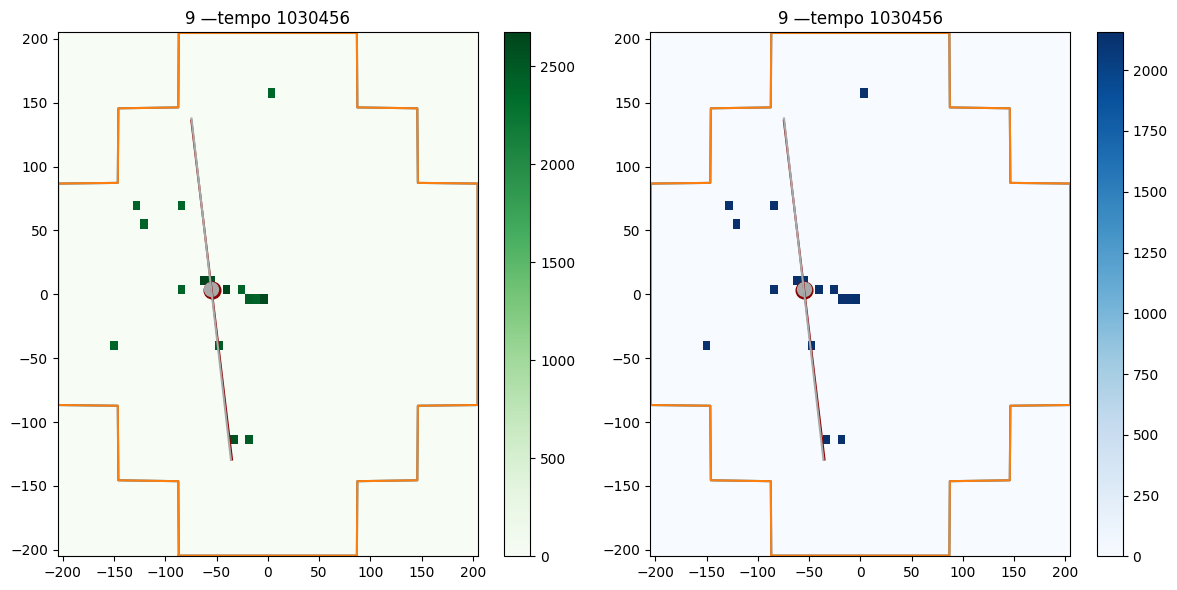

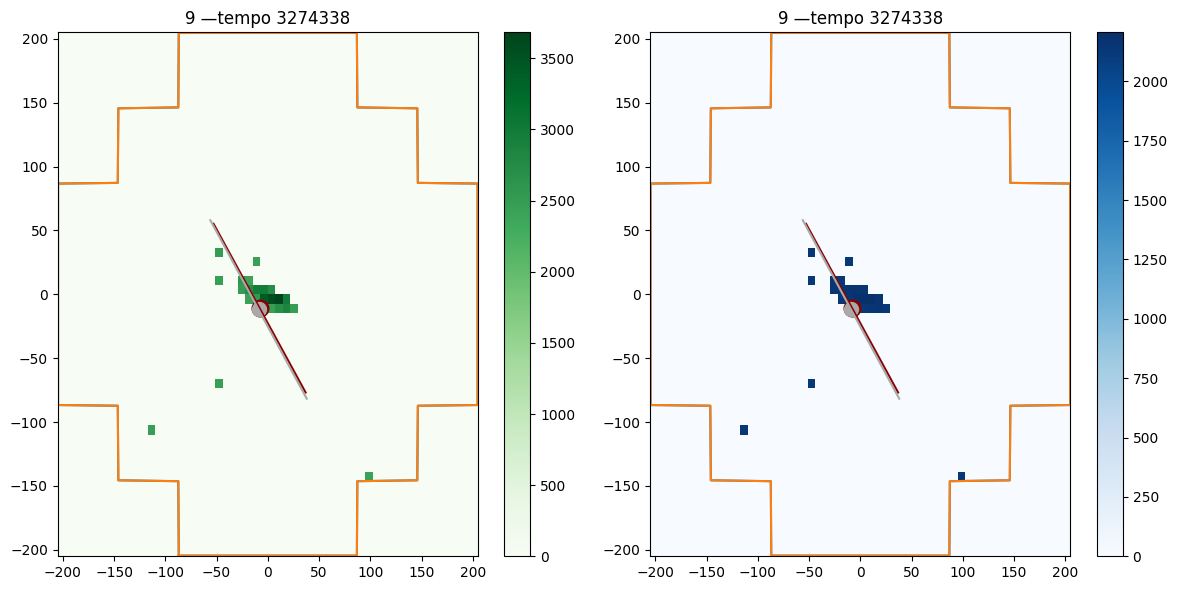

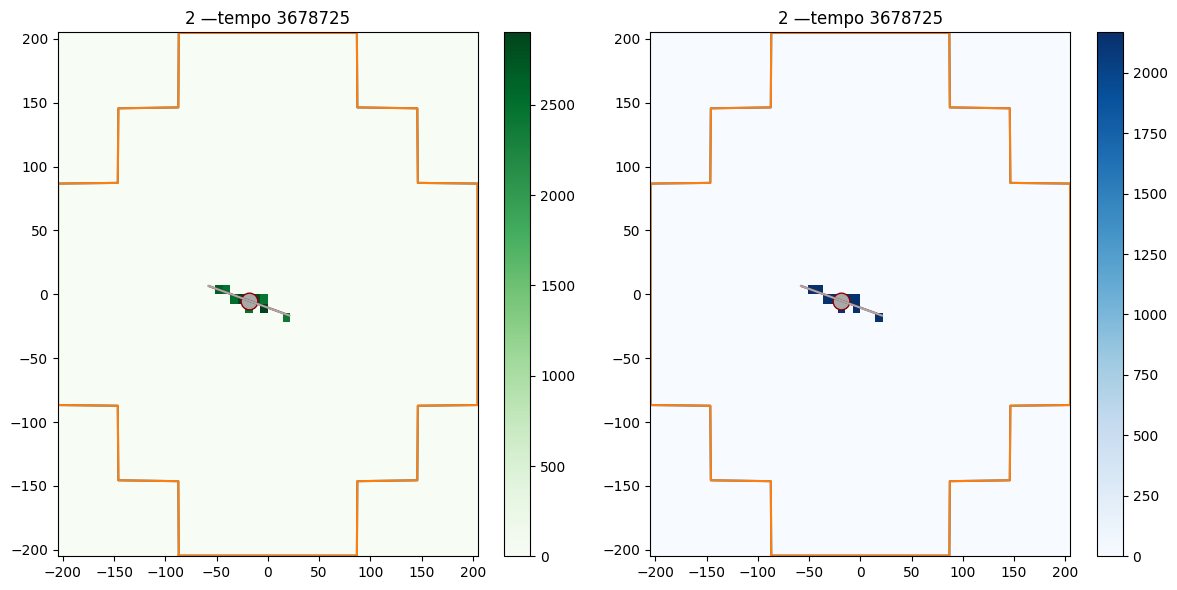

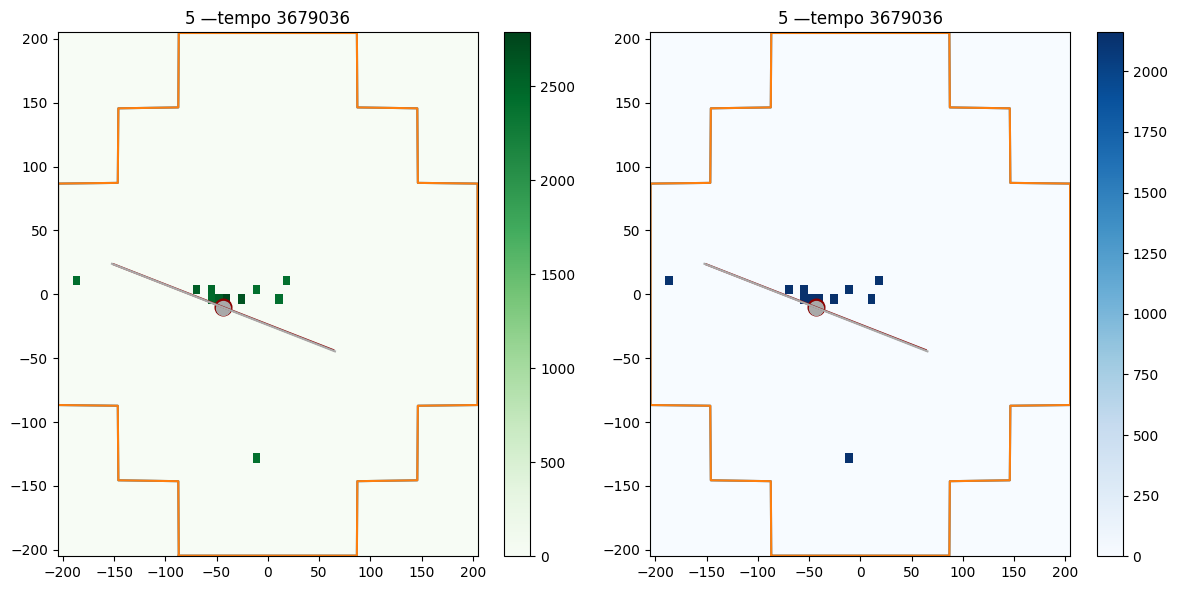

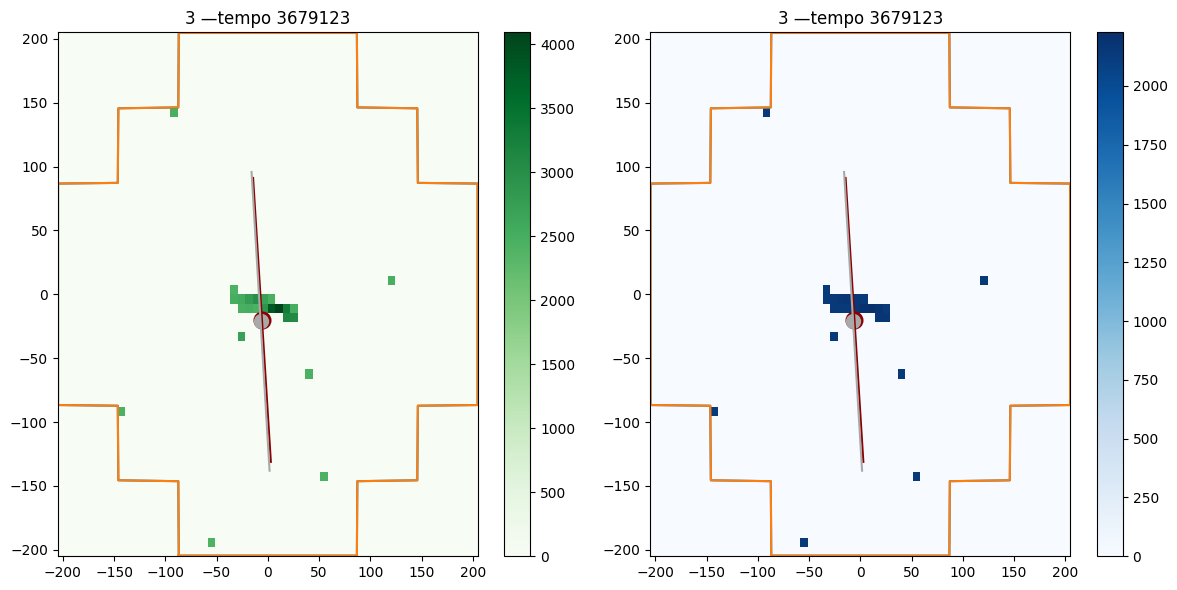

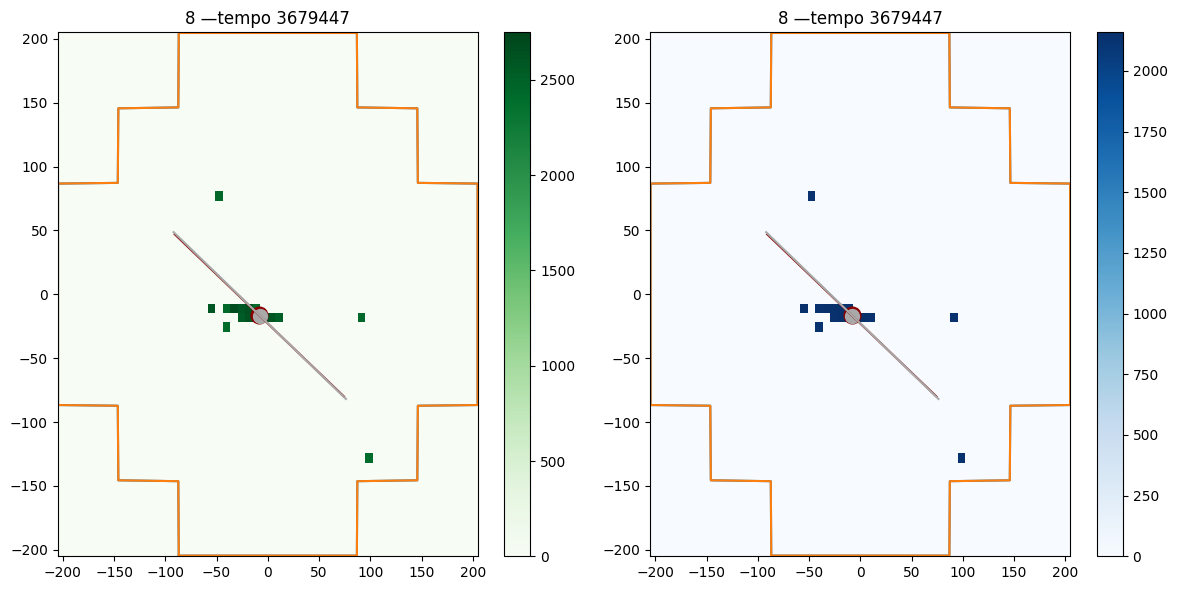

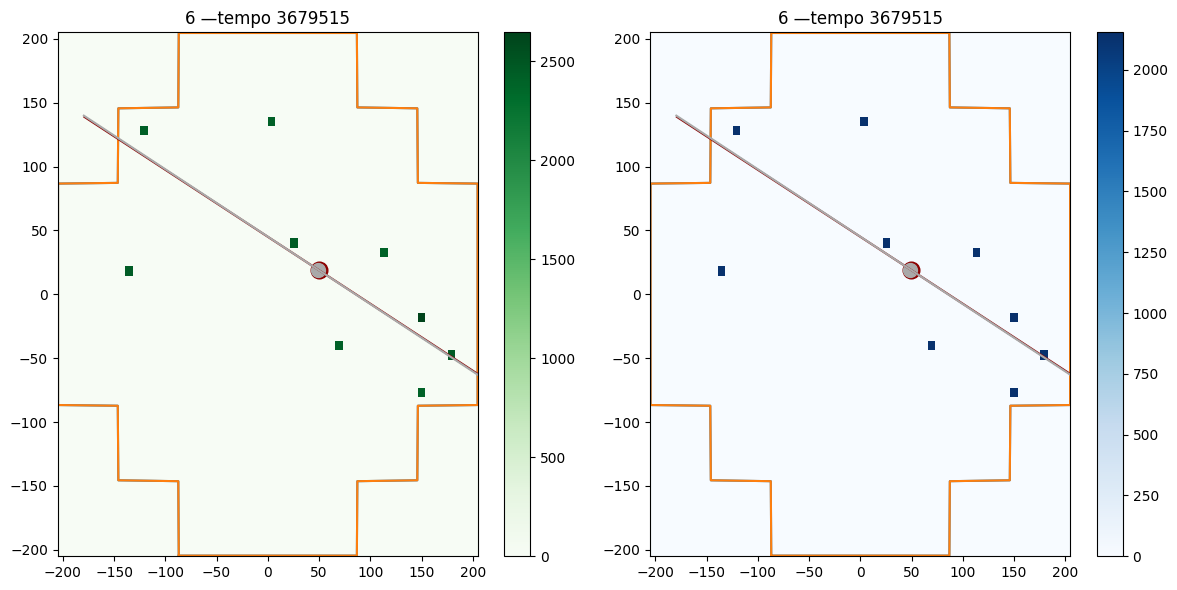

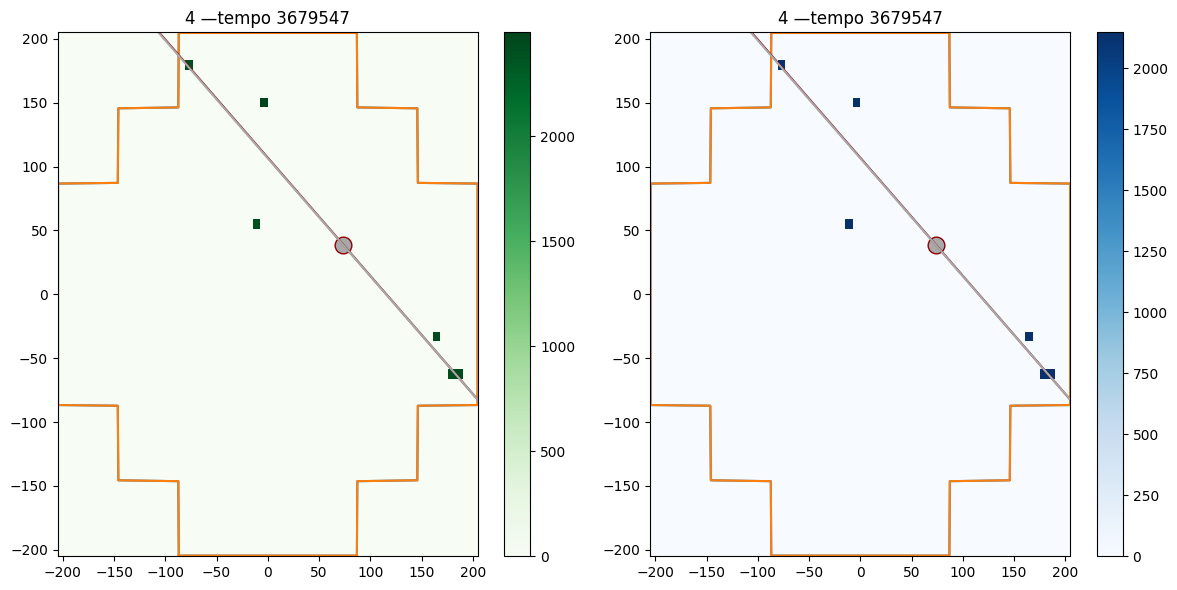

10
10
{'p0': array([-53.35482505,  13.80247121]), 'd': array([0.58880451, 0.80827548]), 'tel': 9}
18897


In [75]:
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

#fig, ax = plt.subplots(figsize=(10, 10))
#ax.plot(xfp, yfp, 'k-', linewidth=1)
rette_hg=[]
rette_lg=[]
for iv in range(10):
    itel=df_dt['TEL_ID'].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })
    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iv]} —tempo {df_all_sorted['TIME_ABS'][iv]}")
            ai.plot(xfp, yfp)
            #centroidi
            ai.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
            ai.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette_hg
            ai.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
            ai.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
    plt.show()
    

print(len(rette_hg))
print(len(rette_lg))
print(rette_hg[0])
print(len(df_dt))

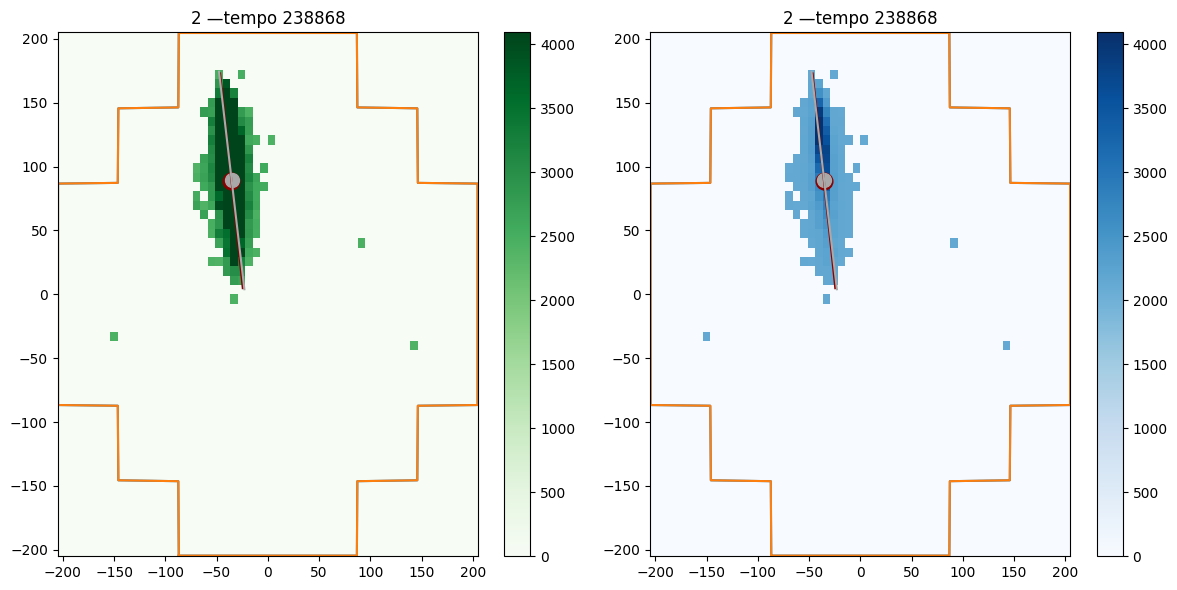

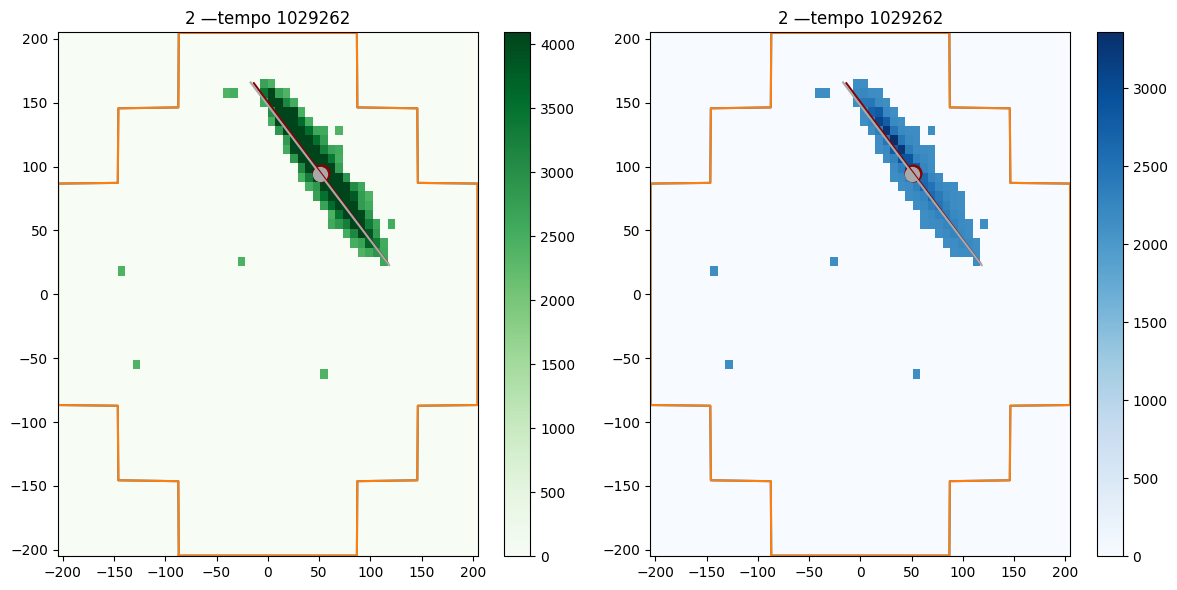

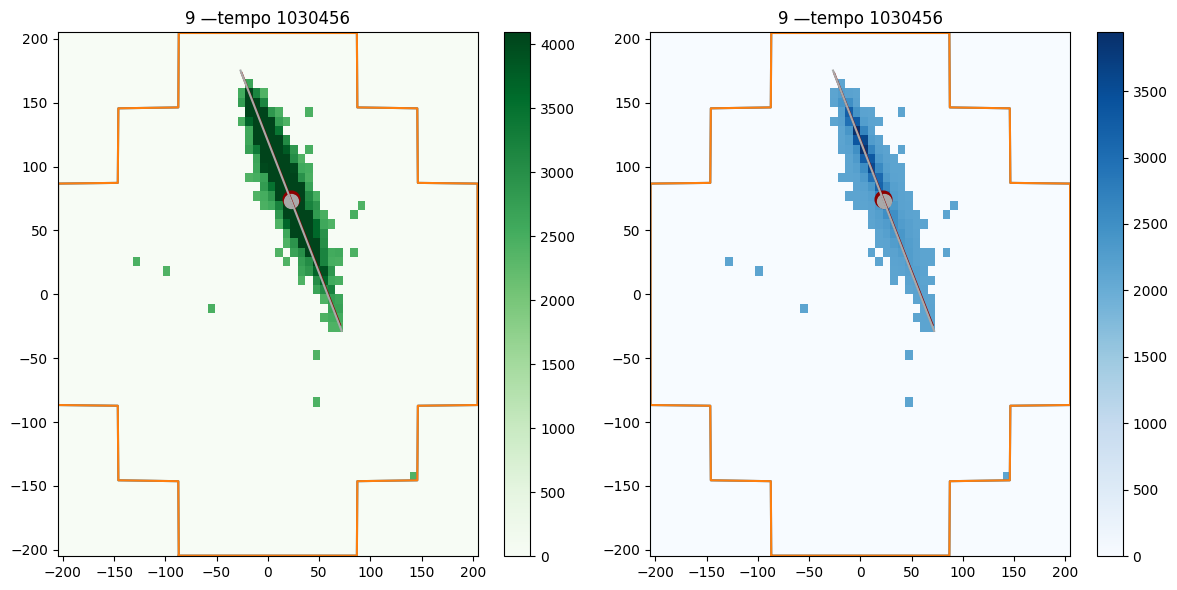

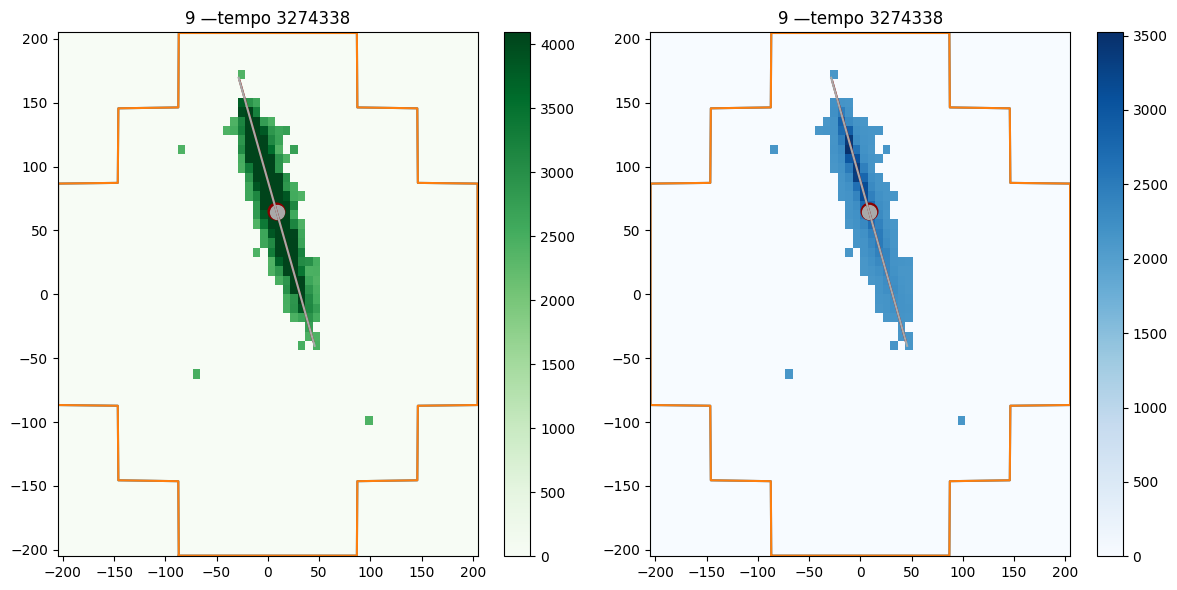

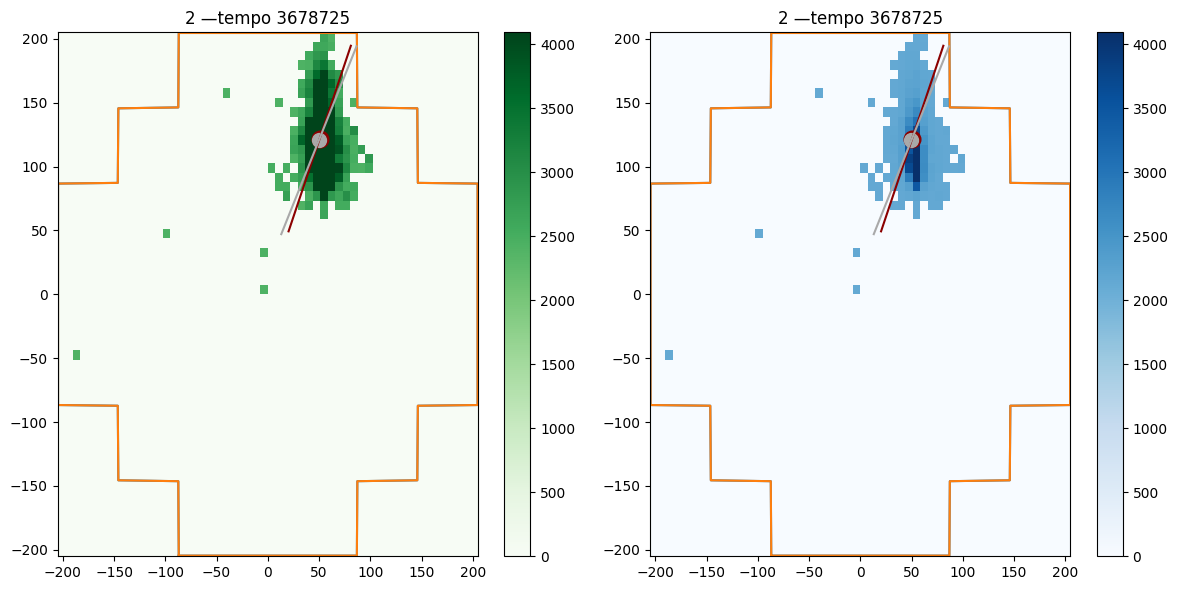

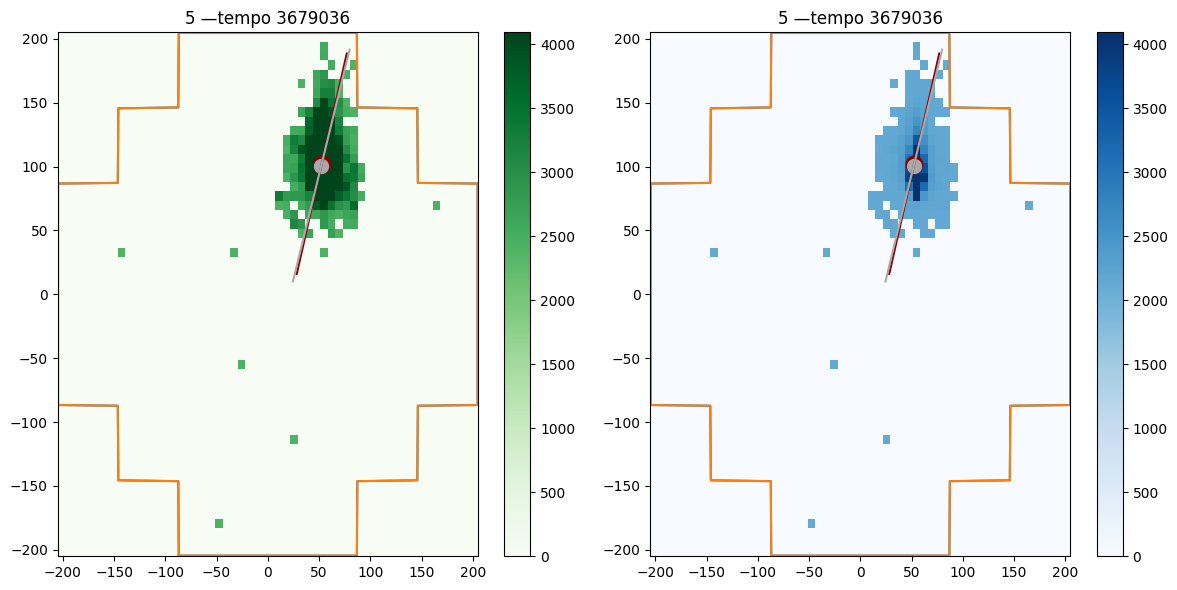

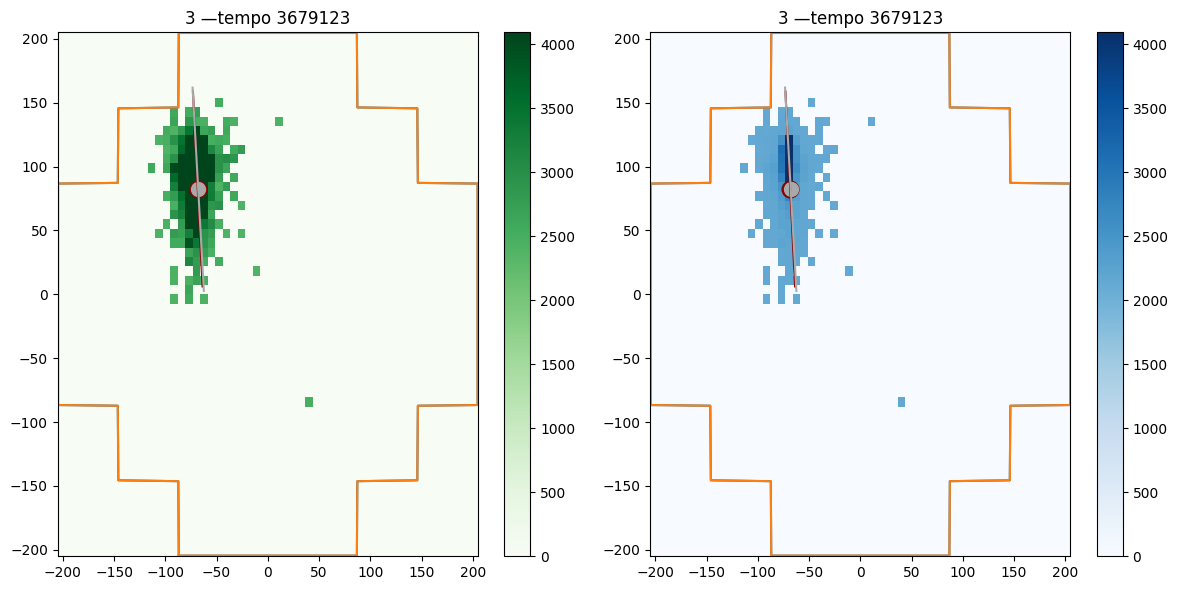

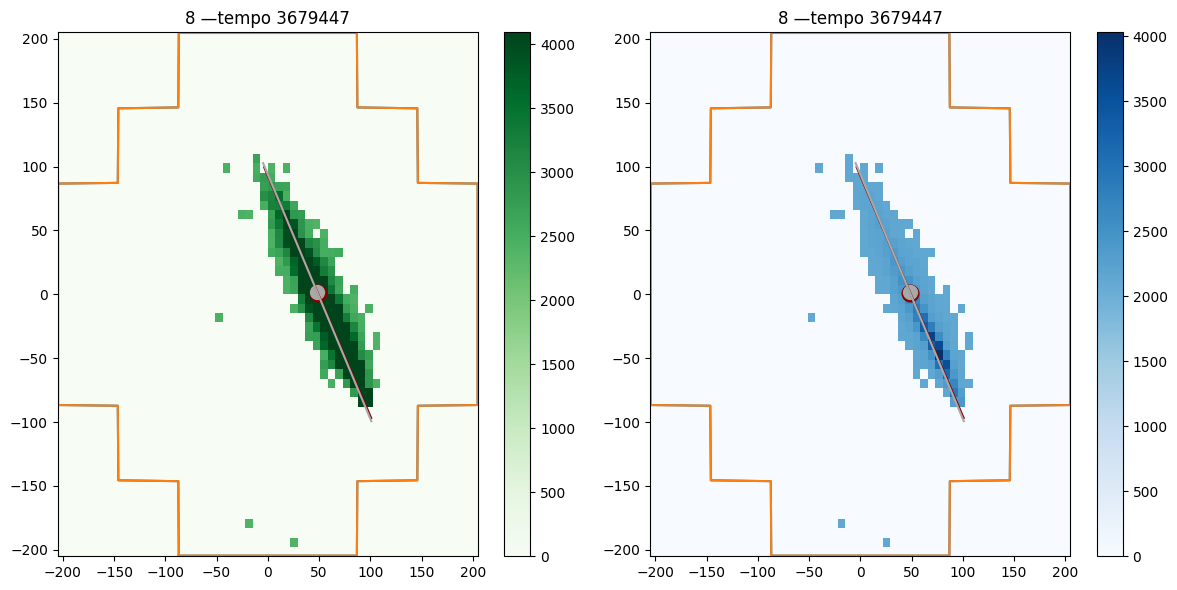

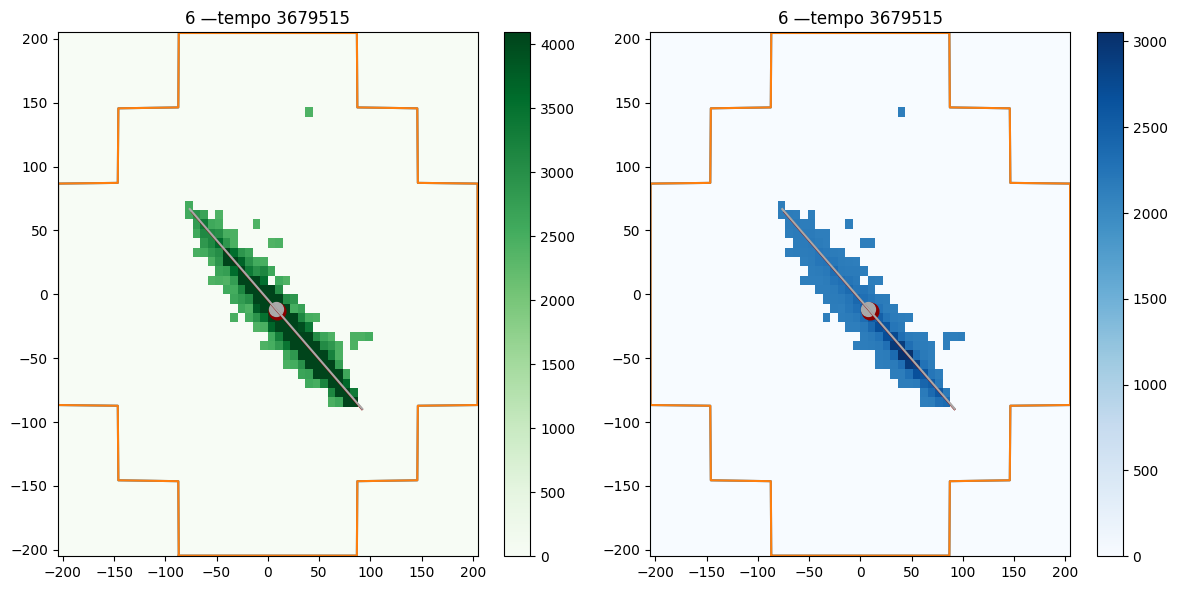

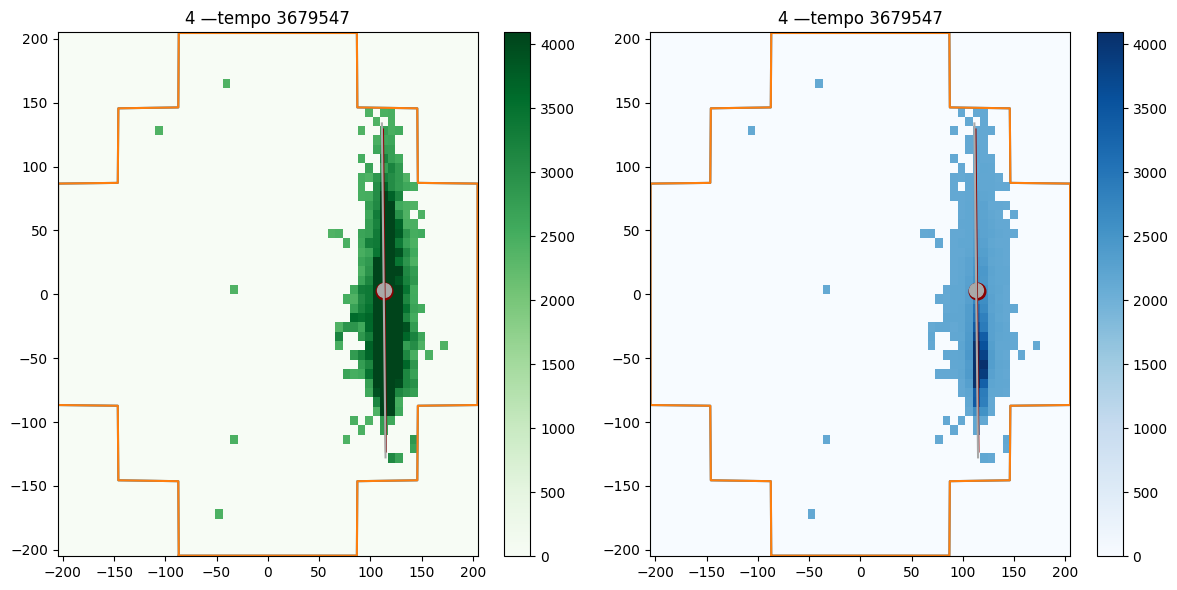

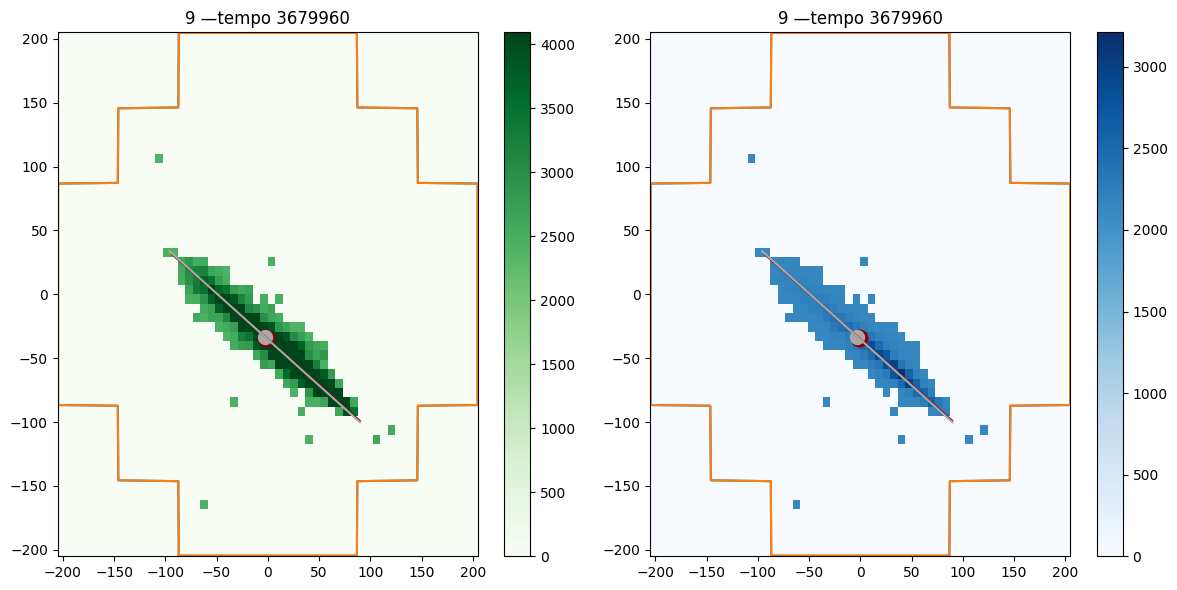

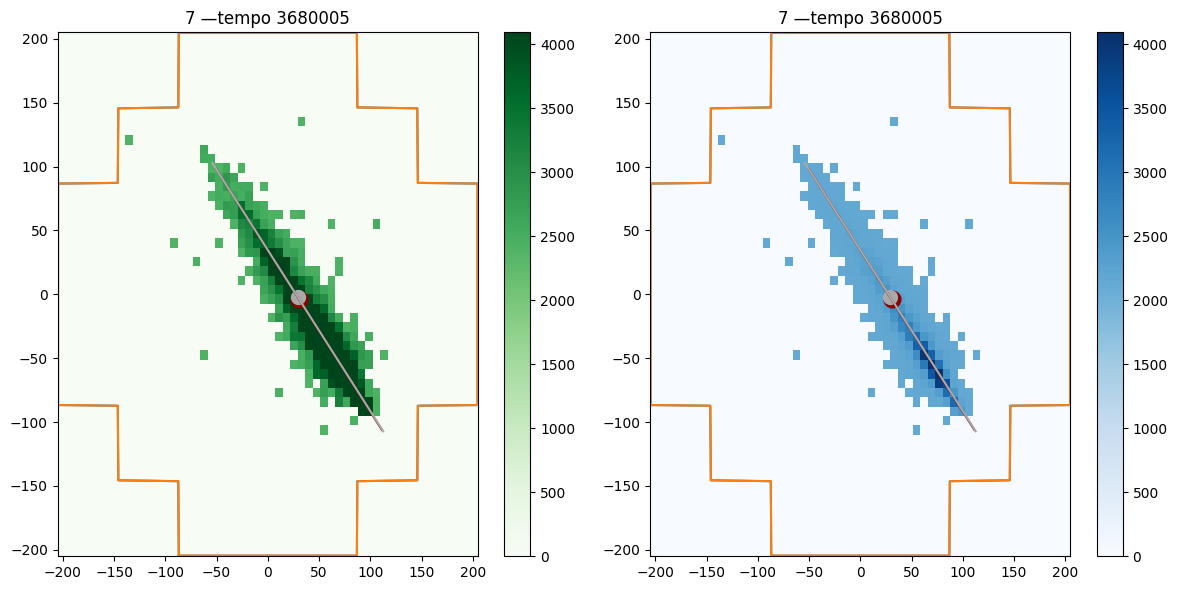

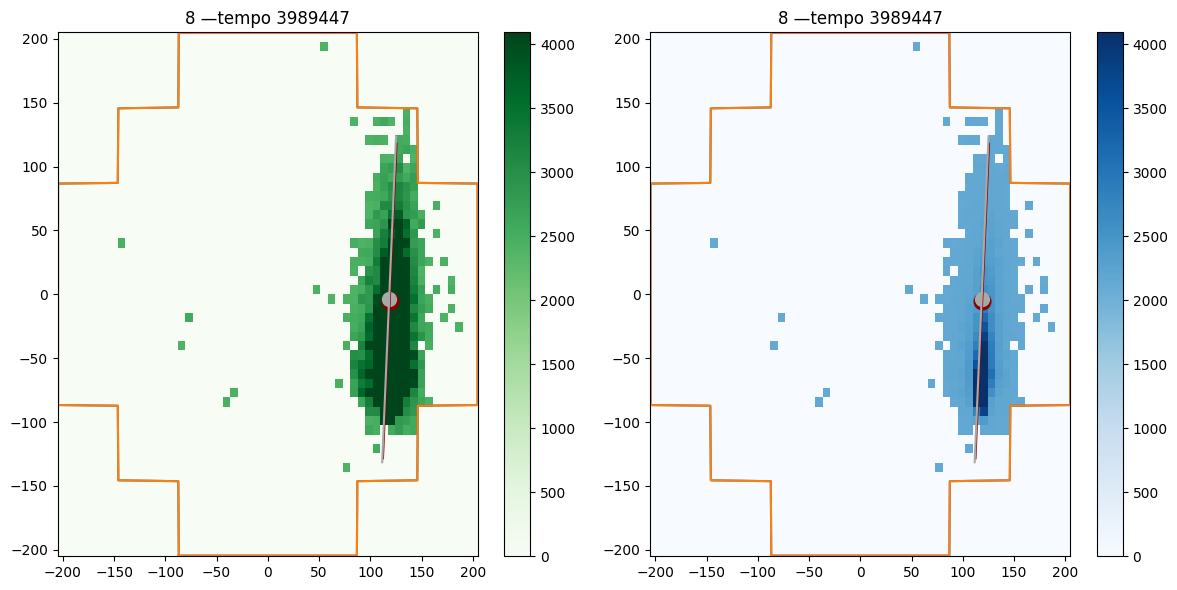

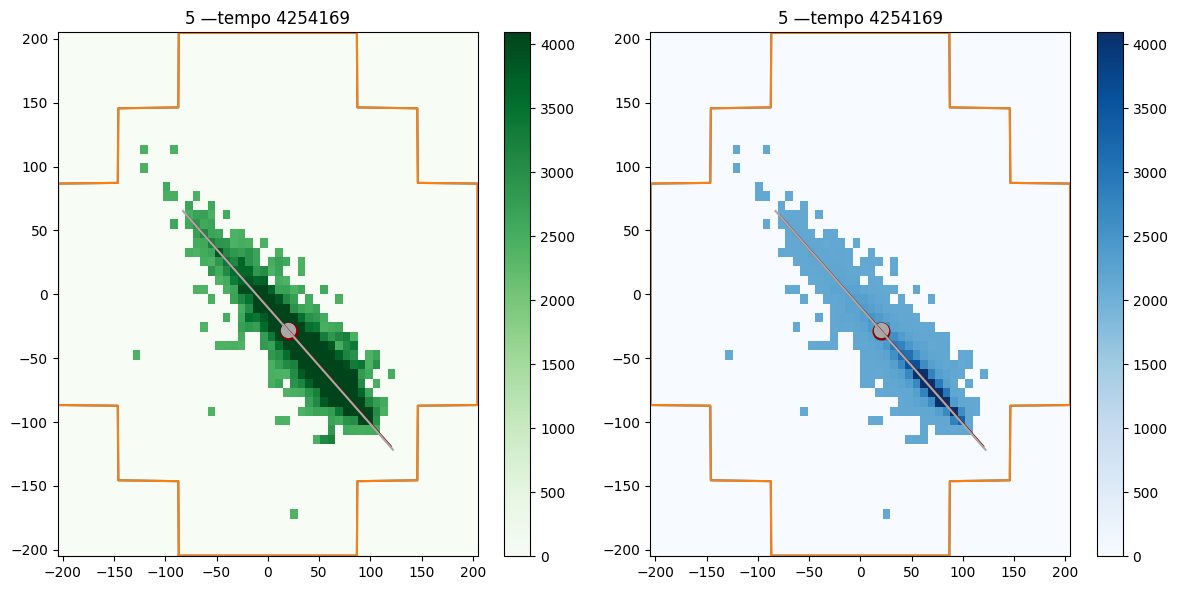

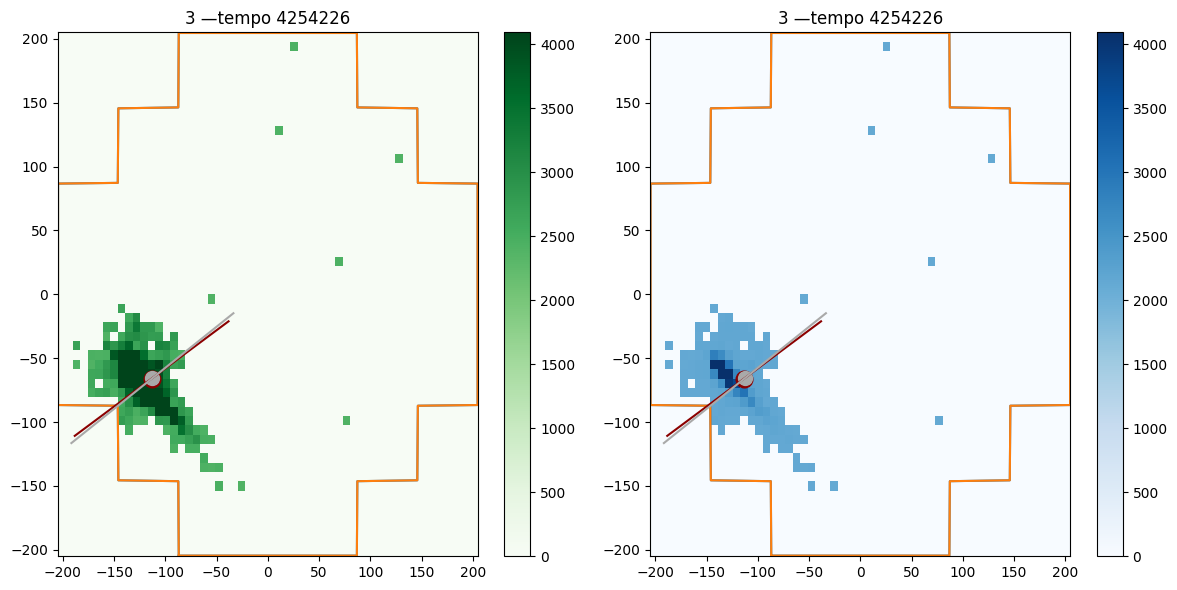

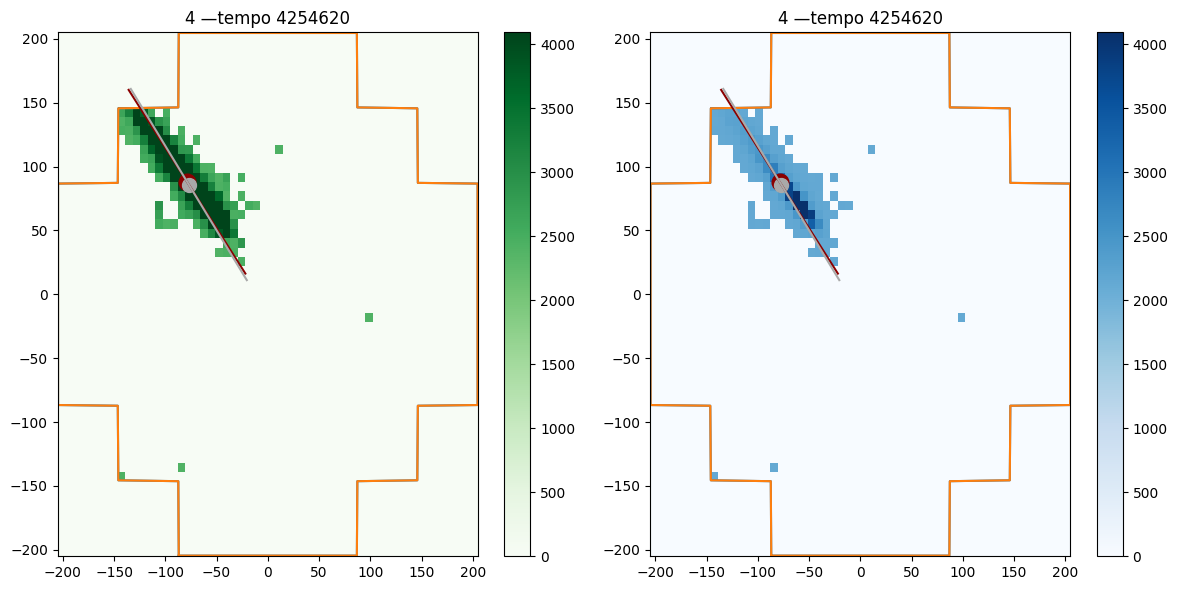

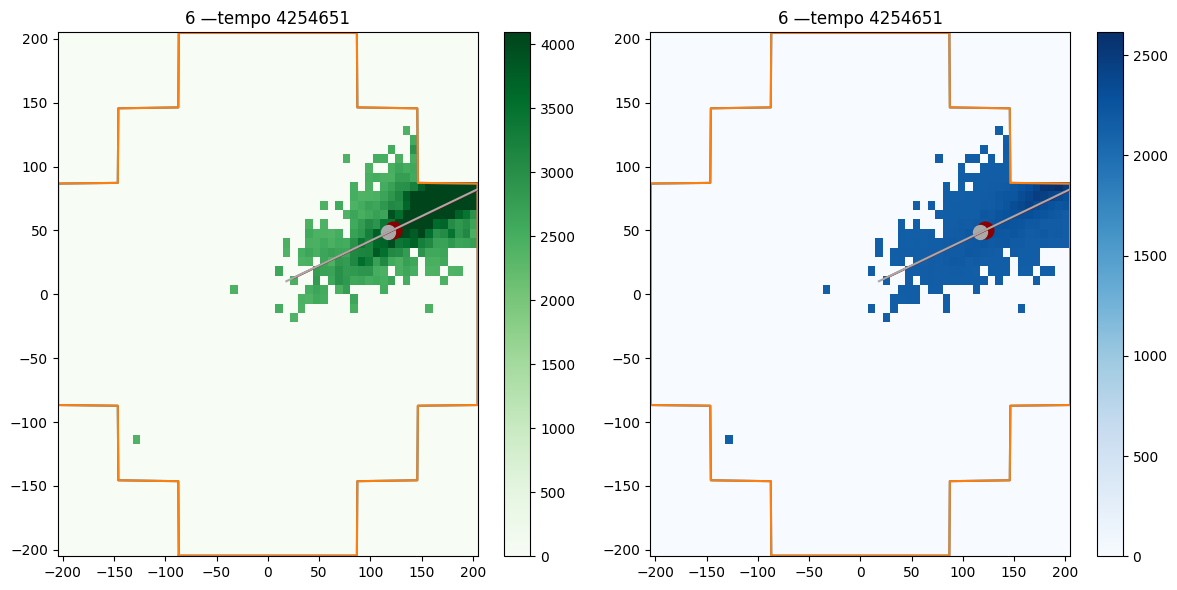

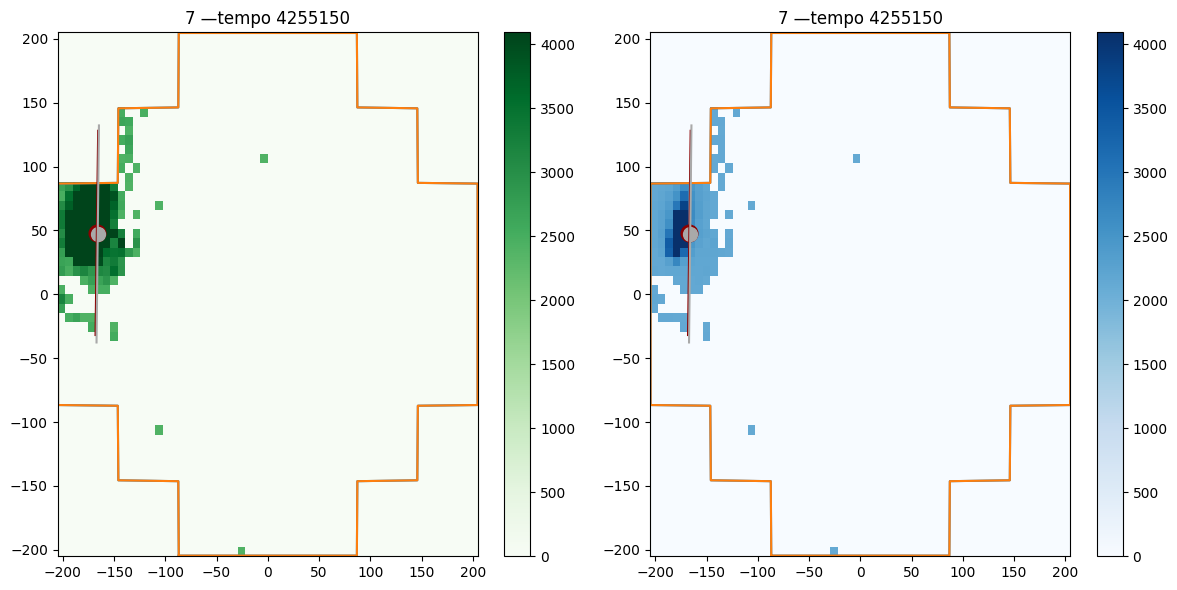

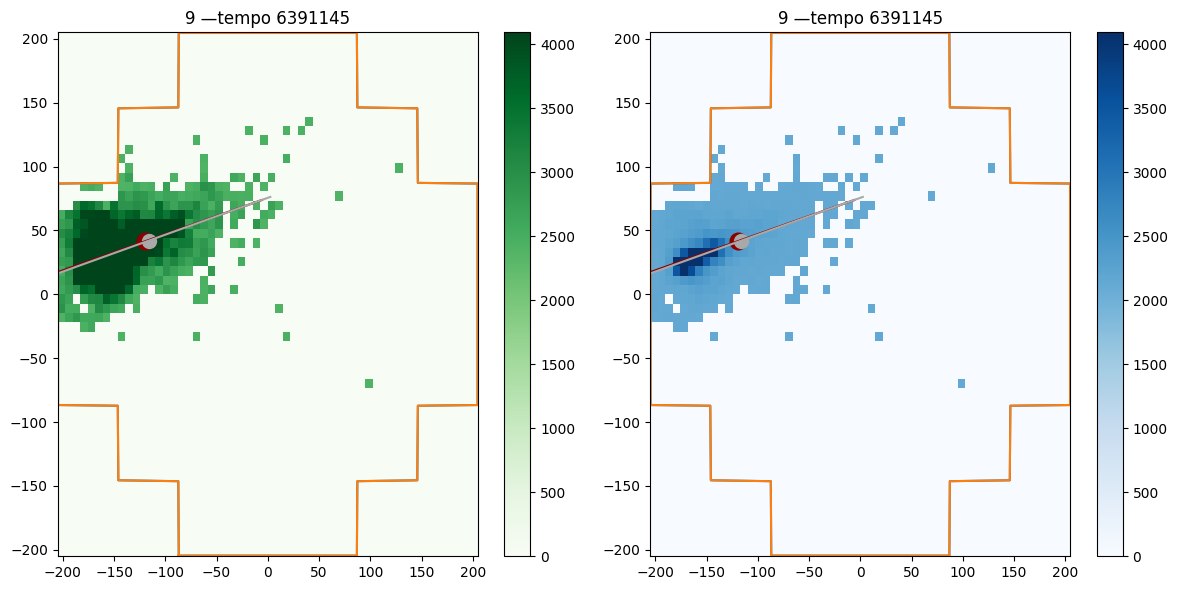

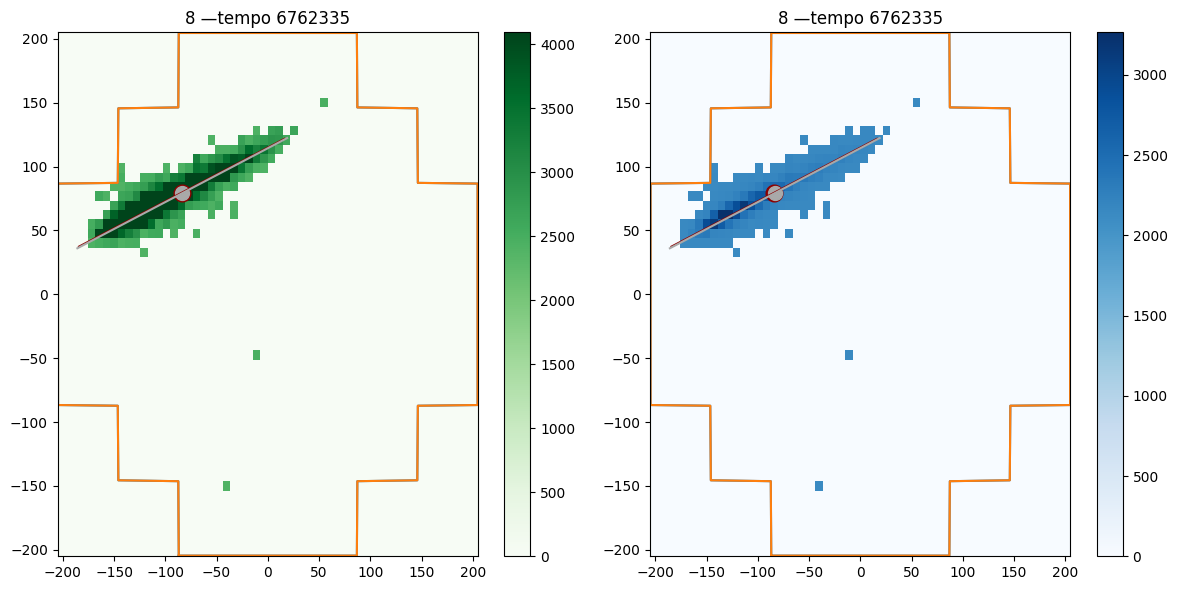

20
20
{'p0': array([-35.4986135 ,  88.81614181]), 'd': array([-0.13056647,  0.99143956]), 'tel': 1}
20


In [81]:
df_dt = df_dt[df_dt["shape"] > 5280425 ]
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

#fig, ax = plt.subplots(figsize=(10, 10))
#ax.plot(xfp, yfp, 'k-', linewidth=1)
rette_hg=[]
rette_lg=[]
for iv in range(len(df_dt)):
    itel=df_dt['TEL_ID'].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })
    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iv]} —tempo {df_all_sorted['TIME_ABS'][iv]}")
            ai.plot(xfp, yfp)
            #centroidi
            ai.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
            ai.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette_hg
            ai.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
            ai.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
    plt.show()
    

print(len(rette_hg))
print(len(rette_lg))
print(rette_hg[0])
print(len(df_dt))

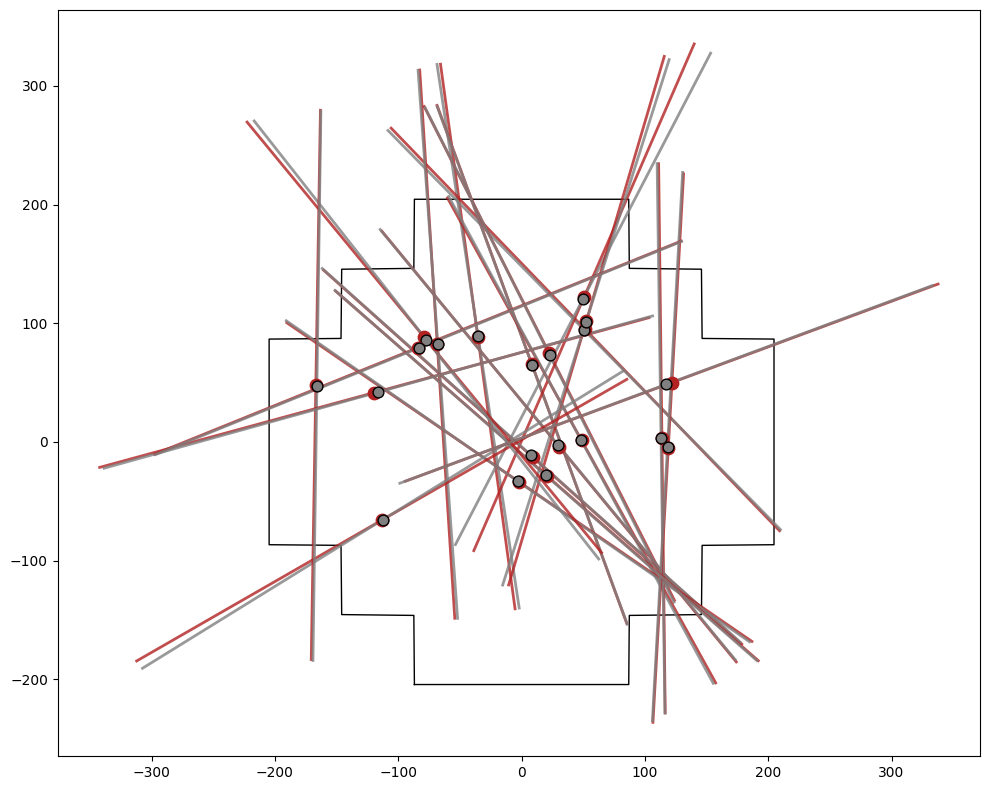

HG: 20
LG: 20
{'p0': array([-35.4986135 ,  88.81614181]), 'd': array([-0.13056647,  0.99143956]), 'tel': 1}


In [82]:
df_dt = df_dt[df_dt["shape"] > 5280425]

xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

# --- FIGURA PRINCIPALE (come nel tuo codice 1) ---
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(xfp, yfp, 'k-', linewidth=1)

xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag

rette_hg = []
rette_lg = []

# ----------------------------------------------------
#                    LOOP TELESCOPI
# ----------------------------------------------------
for iv in range(len(df_dt)):

    itel = df_dt["TEL_ID"].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]

    # mask di pixel buoni
    pxmask = (hgev > 2400) & (ttpev < 255)

    # ---------- centroidi ----------
    meanx_hg = np.average(x_pix[pxmask], weights=hgev[pxmask])
    meany_hg = np.average(y_pix[pxmask], weights=hgev[pxmask])

    meanx_lg = np.average(x_pix[pxmask], weights=lgev[pxmask])
    meany_lg = np.average(y_pix[pxmask], weights=lgev[pxmask])

    # ---------- covarianze ----------
    cov_hg = np.cov([x_pix[pxmask], y_pix[pxmask]], aweights=hgev[pxmask])
    cov_lg = np.cov([x_pix[pxmask], y_pix[pxmask]], aweights=lgev[pxmask])

    # ---------- direzione ellisse ----------
    l1_hg = (cov_hg[0,0] + cov_hg[1,1])/2 + np.sqrt(((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2)
    l1_lg = (cov_lg[0,0] + cov_lg[1,1])/2 + np.sqrt(((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2)

    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])

    # ---------- salva le rette per intersezioni ----------
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })

    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })

    
    # centroidi
    ax.scatter(meanx_hg, meany_hg, s=80, color="firebrick", zorder=5)
    ax.scatter(meanx_lg, meany_lg, s=60, color="grey", edgecolor="black", zorder=5)

    # rette lunghe stile codice 1
    x1 = meanx_hg - L*np.cos(theta_hg)
    y1 = meany_hg - L*np.sin(theta_hg)
    x2 = meanx_hg + L*np.cos(theta_hg)
    y2 = meany_hg + L*np.sin(theta_hg)
    ax.plot([x1, x2], [y1, y2], color='firebrick', linewidth=2, alpha=0.8)

    x1 = meanx_lg - L*np.cos(theta_lg)
    y1 = meany_lg - L*np.sin(theta_lg)
    x2 = meanx_lg + L*np.cos(theta_lg)
    y2 = meany_lg + L*np.sin(theta_lg)
    ax.plot([x1, x2], [y1, y2], color='grey', linewidth=2, alpha=0.8)




plt.tight_layout()
plt.show()

print("HG:", len(rette_hg))
print("LG:", len(rette_lg))
print(rette_hg[0])



In [83]:
def intersection(p1, d1, p2, d2):
    """
    p1, p2 = centroidi
    d1, d2 = direzioni 
    """
    if np.linalg.norm(d1) < 1e-12 or np.linalg.norm(d2) < 1e-12:
        return None
    A = np.array([d1, -d2]).T
    b = p2 - p1

    # determinante per capire se sono parallele
    det = np.linalg.det(A)
    if abs(det) < 1e-6:
        return None  
    # risolvi i parametri t
    t = np.linalg.solve(A, b)[0]

    # punto di intersezione
    return p1 + t * d1
#intersezioni di hg--------------------------------------
N = len(rette_hg)
inters_hg=[]
for i in range(N):
    p1=rette_hg[i]["p0"]
    d1 = rette_hg[i]["d"]
    for j in range(i+1, N):
        p2=rette_hg[j]["p0"]
        d2 = rette_hg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_hg.append(P)
inters_hg = np.array(inters_hg)


v_hg = []
eps=8.#da definire
for i, p in enumerate(inters_hg):
    # distanza p da tutte le altre
    d = np.sqrt(np.sum((inters_hg - p)**2, axis=1))
    # quante intersezioni cadono entro il raggio
    n = np.sum(d < eps)
    # se abbastanza intersezioni vicine 
    if n >= 3:
        v_hg.append(p)

v_hg = np.array(v_hg)
#intersezioni di lg---------------------------------------------
N = len(rette_lg)
inters_lg=[]
for i in range(N):
    p1=rette_lg[i]["p0"]
    d1 = rette_lg[i]["d"]
    for j in range(i+1, N):
        p2=rette_lg[j]["p0"]
        d2 = rette_lg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_lg.append(P)
inters_lg = np.array(inters_lg)


v_lg = []
eps=8.#da definire
for i, p in enumerate(inters_lg):
    # distanza p da tutte le altre
    d = np.sqrt(np.sum((inters_lg - p)**2, axis=1))
    # quante intersezioni cadono entro il raggio
    n = np.sum(d < eps)
    # se abbastanza intersezioni vicine → salva
    if n >= 3:
        v_lg.append(p)

v_lg = np.array(v_lg)
#calcolo media e mediana di lg e hg
centro_hg = np.mean(v_hg, axis=0)
median_hg = np.median(v_hg, axis=0)

centro_lg = np.mean(v_lg, axis=0)
median_lg = np.median(v_lg, axis=0)

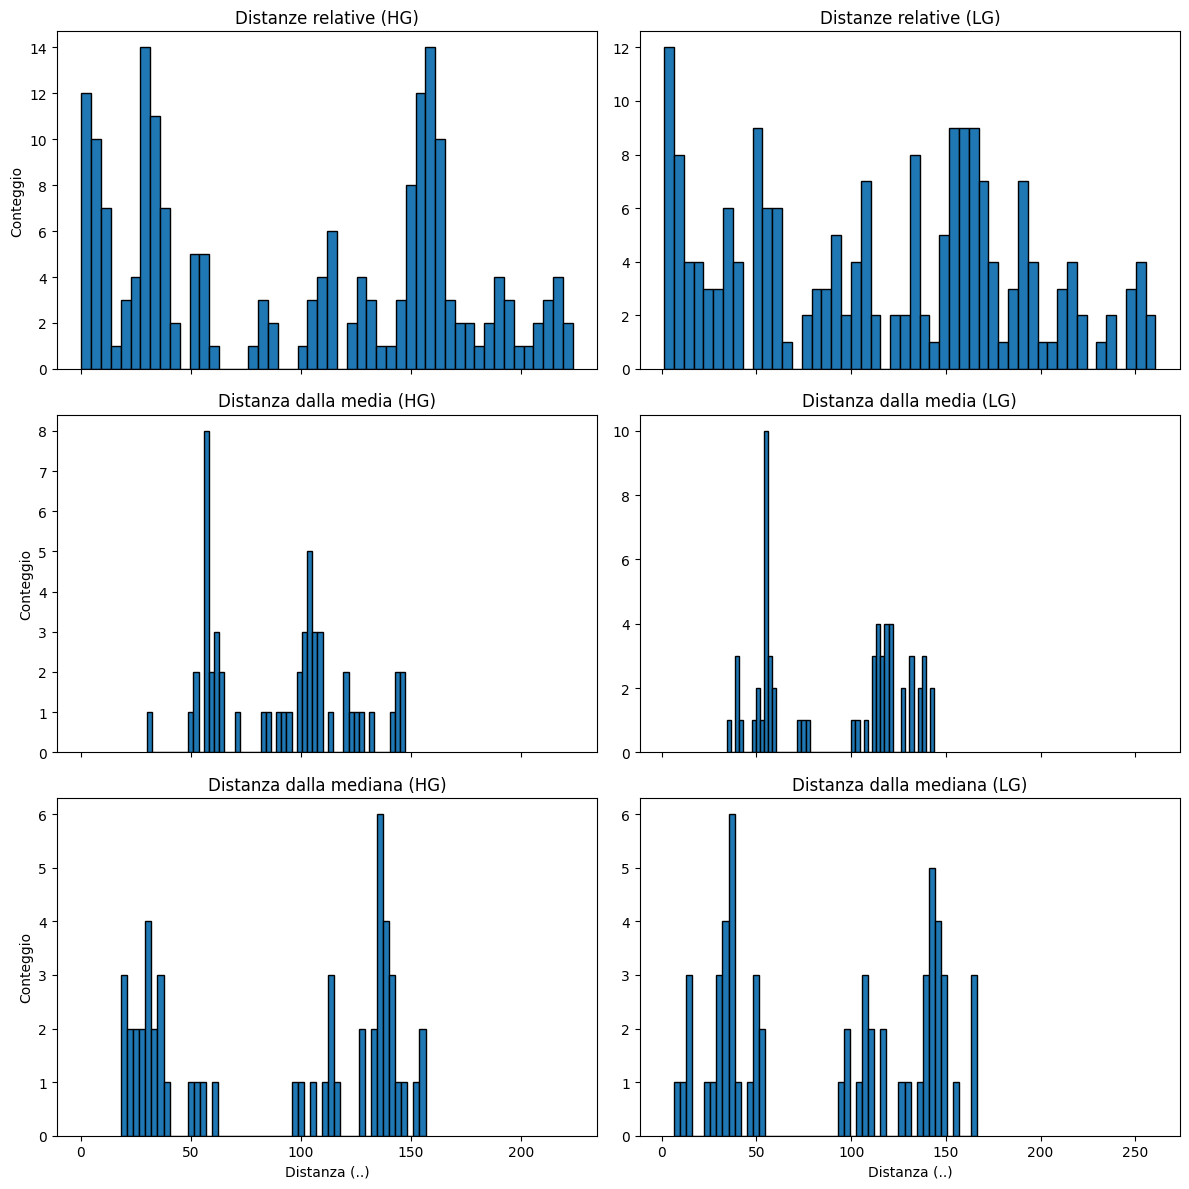

In [84]:
dists_hg = []
for i in range(N):
    for j in range(i+1, N):
        dij = np.linalg.norm(v_hg[i] - v_hg[j])
        dists_hg.append(dij)

dists_hg = np.array(dists_hg)
dists_center_hg = np.linalg.norm(v_hg - centro_hg, axis=1)
dists_median_hg=np.linalg.norm(v_hg - median_hg, axis=1)

dists_lg = []
for i in range(N):
    for j in range(i+1, N):
        dij = np.linalg.norm(v_lg[i] - v_lg[j])
        dists_lg.append(dij)

dists_lg = np.array(dists_lg)
dists_center_lg = np.linalg.norm(v_lg - centro_lg, axis=1)
dists_median_lg = np.linalg.norm(v_lg - median_lg, axis=1)

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex='col')

# -------------------- HG --------------------
#  distanze tra coppie
axes[0,0].hist(dists_hg, bins=50, edgecolor='black')
axes[0,0].set_title("Distanze relative (HG)")
axes[0,0].set_ylabel("Conteggio")

#  distanze dal baricentro
axes[1,0].hist(dists_center_hg, bins=50, edgecolor='black')
axes[1,0].set_title("Distanza dalla media (HG)")
axes[1,0].set_ylabel("Conteggio")

#  distanze dalla mediana
axes[2,0].hist(dists_median_hg, bins=50, edgecolor='black')
axes[2,0].set_title("Distanza dalla mediana (HG)")
axes[2,0].set_xlabel("Distanza (..)")
axes[2,0].set_ylabel("Conteggio")

# -------------------- LG --------------------
#  distanze tra coppie
axes[0,1].hist(dists_lg, bins=50, edgecolor='black')
axes[0,1].set_title("Distanze relative (LG)")

#  distanze dal baricentro
axes[1,1].hist(dists_center_lg, bins=50, edgecolor='black')
axes[1,1].set_title("Distanza dalla media (LG)")

#  distanze dalla mediana
axes[2,1].hist(dists_median_lg, bins=50, edgecolor='black')
axes[2,1].set_title("Distanza dalla mediana (LG)")
axes[2,1].set_xlabel("Distanza (..)")

plt.tight_layout()
plt.show()